# Support Vector Machine


In [55]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
iris = datasets.load_iris();
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
X = iris['data'][:,(2,3)];#petal lengght, petal width
y = (iris['target']==2).astype(np.float64);

In [4]:
svm_clf = Pipeline([("scaler", StandardScaler()),("linear_svc", LinearSVC(C=1, loss='hinge'))])

In [5]:
svm_clf.fit(X, y);

In [6]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

Unlike Logistic regression it does not output probabilities.

Also the **SVC** class exists (using *SVC(kernel='linear', C=1)*) but it is much slower. Another option is to use the `SGDClassifier` class, with `SGDClassifier(loss="hinge", alpha=1/(m*C))`. This applies regular Stochastic Gradient Descent to train a linear SVM classifier. It does not converge as fast as the `LinearSVC` class, but it can be useful to handle huge datasets that do not fit in memory (out-of-core training), or to handle online classification tasks.

The LinearSVC class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the StandardScaler. Moreover, make sure you set the loss hyperparameter to "hinge", as it is not the default value. Finally, for better performance you should set the dual hyperparameter to False, unless there are more features than training instances (we will discuss duality later in the chapter).

## FROM Stackoverflow

Mathematically, optimizing an SVM is a convex optimization problem, usually with a unique minimizer. This means that there is only one solution to this mathematical optimization problem.

The differences in results come from several aspects: `SVC` and `LinearSVC` are supposed to optimize the same problem, but in fact all `liblinear` estimators penalize the intercept, whereas `libsvm` ones don't (IIRC). This leads to a different mathematical optimization problem and thus different results. There may also be other subtle differences such as scaling and default loss function (edit: make sure you set `loss='hinge'` in `LinearSVC`). Next, in multiclass classification, `liblinear` does one-vs-rest by default whereas `libsvm` does one-vs-one.

`SGDClassifier(loss='hinge')` is different from the other two in the sense that it uses stochastic gradient descent and not exact gradient descent and may not converge to the same solution. However the obtained solution may generalize better.

Between `SVC` and `LinearSVC`, one important decision criterion is that `LinearSVC` tends to be faster to converge the larger the number of samples is. This is due to the fact that the linear kernel is a special case, which is optimized for in Liblinear, but not in Libsvm.


### another
In mathematical sense you need to set:

    SVC(kernel='linear', **kwargs) # by default it uses RBF kernel

and

    LinearSVC(loss='hinge', **kwargs) # by default it uses squared hinge loss

Another element, which cannot be easily fixed is increasing `intercept_scaling` in `LinearSVC`, as in this implementation bias is regularized (which is not true in SVC nor should be true in SVM - thus **this is not SVM**) - consequently they will **never** be exactly equal (unless bias=0 for your problem), as they assume two different models

* SVC : `1/2||w||^2 + C SUM xi_i`
* LinearSVC: `1/2||[w b]||^2 + C SUM xi_i`

Personally I consider LinearSVC one of the mistakes of sklearn developesr - this class is simply **not a linear SVM**.

After increasing intercept scaling (to `10.0`)

[![SVMs][1]][1]

However, if you scale it up too much - it will also fail, as now tolerance and number of iterations are crucial.

To sum up: **LinearSVC is not linear SVM, do not use it if do not have to.**


## Non linear SVM classification
https://stackoverflow.com/a/35081862/1714692

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to being linearly separable. One approach to handling nonlinear datasets is to add more features, such as polynomial features.


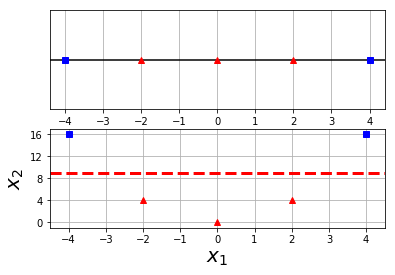

In [7]:
x = np.array([-4,-2,0,2,4]).reshape((5,1))
y = np.array([1,0,0,0,1]).reshape((5,1))

plt.subplot(211)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(x[y==0],np.zeros((3,1)), 'r^')
plt.plot(x[y==1], np.zeros((2,1)),'bs')
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("r$x_1$", fontsize=20)


x = np.concatenate([x, np.square(x)], axis=1)

plt.subplot(212)
plt.grid(True, which='both')
plt.gca().get_yaxis().set_ticks([])
plt.plot(x[(y==0).reshape(x.shape[0]),0], x[(y==0).reshape(x.shape[0]),1], 'r^')
plt.plot(x[(y==1).reshape(x.shape[0]),0], x[(y==1).reshape(x.shape[0]),1],'bs')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
k=9
plt.plot([-4.5, 4.5], [k, k], "r--", linewidth=3)
plt.axis([-4.5,4.5,-1,17])
plt.show()
#plt.plot(x[y==0], 'r^')
#plt.plot(x[y==1], 'bs')



To extend the features, one can create a **`Pipeline`** containing a **`PolynomialFeatures`** transformer, followed by a **`StandardScaler`** and a **`LinearSVC`**. Let’s test this on the moons dataset: this is a toy dataset for binary classification in which the data points are shaped as two interleaving half circles. You can generate this dataset using the `make_moons()` function:

In [8]:
from sklearn.datasets import make_moons
help(make_moons)

Help on function make_moons in module sklearn.datasets.samples_generator:

make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)
    Make two interleaving half circles
    
    A simple toy dataset to visualize clustering and classification
    algorithms. Read more in the :ref:`User Guide <sample_generators>`.
    
    Parameters
    ----------
    n_samples : int, optional (default=100)
        The total number of points generated.
    
    shuffle : bool, optional (default=True)
        Whether to shuffle the samples.
    
    noise : double or None (default=None)
        Standard deviation of Gaussian noise added to the data.
    
    random_state : int, RandomState instance or None (default)
        Determines random number generation for dataset shuffling and noise.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    
    Returns
    -------
    X : array of shape [n_samples, 2]
        The 

Pipeline(memory=None,
     steps=[('PolynomialFeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

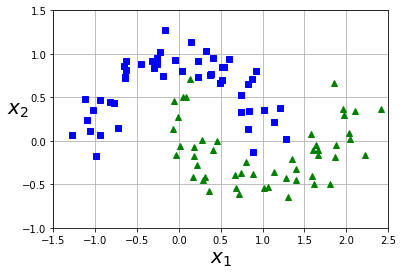

In [9]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def plot_dataset(X,y, axes=None):
    plt.plot(X[:,0][y==0],X[:,1][y==0], 'bs');
    plt.plot(X[:,0][y==1],X[:,1][y==1], 'g^');
    if axes:
        plt.axis(axes);
    plt.grid(True, which='both');
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
X,y = make_moons(n_samples=100, noise=0.15, random_state=42);    
plot_dataset(X,y, [-1.5, 2.5, -1, 1.5])
    
polynomial_svm_clf = Pipeline([
    ('PolynomialFeatures', PolynomialFeatures(degree=3)),
    ('Scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge',random_state=42))]);

polynomial_svm_clf.fit(X,y)

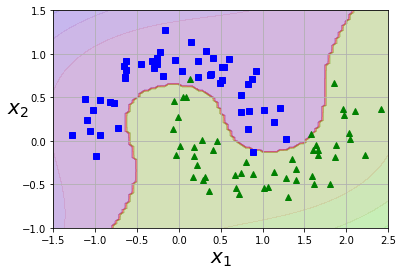

In [10]:
def plotPrediction(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100);
    x1s = np.linspace(axes[2], axes[3], 100);
    x0, x1 = np.meshgrid(x0s, x1s);
    X = np.c_[x0.ravel(), x1.ravel()];#translates slice objects to concatenation along the second axis.
    y_pred = clf.predict(X).reshape(x0.shape);
    y_decision = clf.decision_function(X).reshape(x0.shape);
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2);
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1);
    
s =[-1.5, 2.5, -1, 1.5];
plotPrediction(polynomial_svm_clf, s);
plot_dataset(X,y, s);

Adding polynomial features is simple to implement and can work great with all sorts of Machine Learning algorithms (not just SVMs), but at a low polynomial degree it cannot deal with very complex datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow.


**kernel trick** makes it possible to get the same result as if you added many polynomial features, even with very high-degree polynomials, without actually having to add them. So there is **no combinatorial explosion** of the number of features since you don’t actually add any features. This trick is implemented by the SVC class. Let’s test it on the moons dataset.
The hyperparameter **`coef0`** controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

A common approach to find the right hyperparameter values is to use grid search. It is often faster to first do a very coarse grid search, then a finer grid search around the best values found. Having a good sense of what each hyperparameter actually does can also help you search in the right part of the hyperparame‐ ter space.



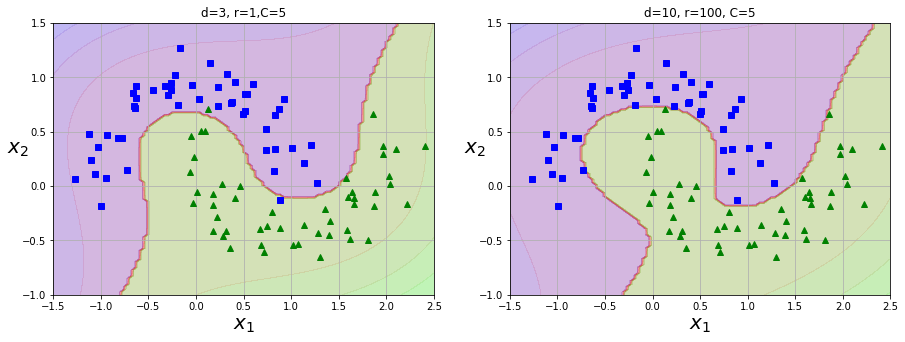

In [11]:
from sklearn.svm import SVC;
polynomial_svm_clf3 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
]);
polynomial_svm_clf3.fit(X,y);

polynomial_svm_clf10 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5))
]);
polynomial_svm_clf10.fit(X,y);
f, axs = plt.subplots(2,2,figsize=(15,5))
plt.subplot(121);
s =[-1.5, 2.5, -1, 1.5];
#%matplotlib inline
plotPrediction(polynomial_svm_clf3,s);
plot_dataset(X,y);
plt.title('d=3, r=1,C=5');
plt.subplot(122);
plotPrediction(polynomial_svm_clf10,s);
plot_dataset(X,y);
plt.title('d=10, r=100, C=5');

## Adding Similarity features
Another technique to tackle nonlinear problems is to add features computed using a similarity function that measures how much each instance resembles a particular landmark. For example, let’s take the one-dimensional dataset discussed earlier and add two landmarks to it at $x_1 = –2$ and $x_1 = 1$. Next, let’s define the similarity function to be the Gaussian Radial Basis Function (RBF) with $\gamma = 0.3$.

Gaussian Radial Basis Function:
$$
\Phi (x,\ell) = exp(-\gamma, \left| x-\ell\right|^2)
$$

It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark).

It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark). Now we are ready to compute the new features. For example, let’s look at the instance x1 = –1: it is located at a distance of 1 from the first landmark, and 2 from the second landmark. Therefore its new features are $x_2 = exp (–0.3 × 12) \approx 0.74$ and $x_3 = exp (–0.3 × 22) \approx 0.30$.


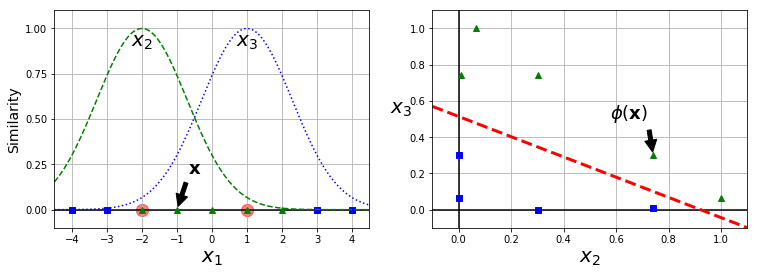

In [12]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

#save_fig("kernel_method_plot")
plt.show()

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset.
This creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with m instances and n features gets transformed into a training set with m instances and m features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

However, once again the kernel trick does its SVM magic: it makes it possible to obtain a similar result as if you had added many similarity features, without actually having to add them. Let’s try the Gaussian RBF kernel using the SVC class

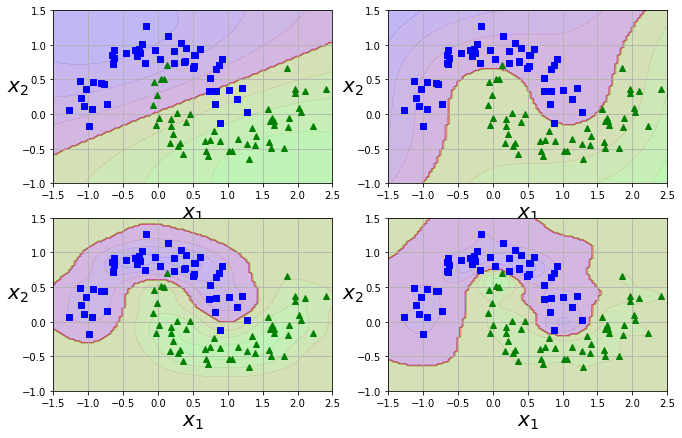

In [13]:
gamma1, gamma2 = 0.1, 5;
C1, C2 = 0.001, 1000;
hyperparams = (gamma1, C1),(gamma1, C2),(gamma2, C1),(gamma2, C2);
svm_clfs = list();
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', gamma=gamma, C=C))]);
    rbf_kernel_svm_clf.fit(X,y);
    svm_clfs.append(rbf_kernel_svm_clf);

plt.figure(figsize=(11,7))
for i,model in enumerate(svm_clfs):
    plt.subplot(2,2,i+1);
#    plotPrediction()
    X0s = np.linspace(-1.5, 2.5,100);
    X1s = np.linspace(-1, 1.5,100);
    X0, X1 = np.meshgrid(X0s,X1s);
    X_mesh = np.c_[X0.ravel(), X1.ravel()];
    y_pred = model.predict(X_mesh).reshape(X0.shape);
    y_decision = model.decision_function(X_mesh).reshape(X0.shape);
    plt.contourf(X0s, X1s, y_pred, cmap= plt.cm.brg, alpha=0.2);
    plt.contourf(X0s, X1s, y_decision, cmap= plt.cm.brg, alpha=0.1)
    plot_dataset(X,y)


Increasing gamma makes the bell-shape curve narrower (see the left plot of the above Figure), and as a result each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider, so instances have a larger range of influence, and the decision boundary ends up smoother. So $\gamma$ acts like a regularization hyperparameter: if your model is overfitting, you should reduce it, and if it is under‐ fitting, you should increase it (similar to the C hyperparameter).

Other kernels exist but are used much more rarely. For example, some kernels are specialized for specific data structures. String kernels are sometimes used when classi‐ fying text documents or DNA sequences.

As a rule of thumb, you should always try the linear kernel first (remember that LinearSVC is much faster than SVC(ker nel="linear")), especially if the training set is very large or if it has plenty of features. If the training set is not too large, you should try the Gaussian RBF kernel as well; it works well in most cases.

Then if you have spare time and computing power, you can also experiment with a few other kernels using cross-validation and grid search, especially if there are kernels specialized for your training set’s data structure.

## Computational complexity
The LinearSVC class is based on the liblinear library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features: its training time complexity is roughly $O(m \times n)$.
The algorithm takes longer if you require a very high precision. This is controlled by the tolerance hyperparameter ε (called `tol` in Scikit-Learn). In most classification tasks, the default tolerance is fine. The SVC class is based on the libsvm library, which implements an algorithm that supports the kernel trick. The training time complexity is usually between $O(m^2 \times n)$ and $O(m^3 \times n)$. Unfortunately, this means that it gets dreadfully slow when the number of training instances gets large (e.g., hundreds of thousands of instances). This algorithm is perfect for complex but small or medium training sets. However, it scales well with the number of features, especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm scales roughly with the average number of nonzero features per instance. Table 5-1 compares Scikit-Learn’s SVM classification classes.

<img src= SVMComparison.png>

In [14]:
!pwd

/Users/fra/Documents/OtherMaterial/machineLearningNotes/scripts/SVM


# SVM Regression
As we mentioned earlier, the SVM algorithm is quite versatile: not only does it support linear and nonlinear classification, but it also supports linear and nonlinear regression.

The trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances off the street)

The width of the street is controlled by a hyperparameter $\epsilon$.

In [15]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

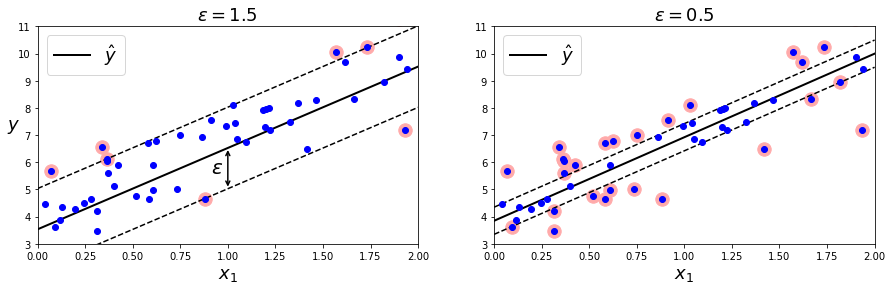

In [16]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42);
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42);
svm_reg1.fit(X, y);
svm_reg2.fit(X, y);

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y);
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y);

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
#save_fig("svm_regression_plot")
plt.show()

To tackle nonlinear regression tasks, you can use a kernelized SVM model. For example, the figures shows SVM Regression on a random quadratic training set, using a 2nd-degree polynomial kernel:

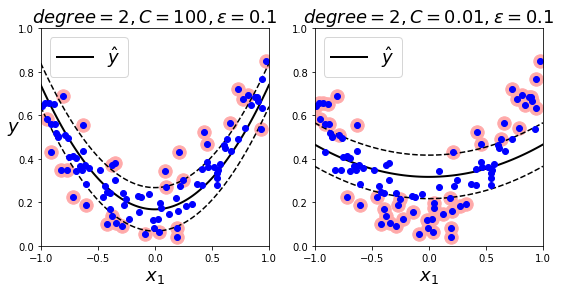

In [17]:
from sklearn.svm import SVR
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
svm_poly_reg.fit(X, y)

from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="auto")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)


plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
#save_fig("svm_with_polynomial_kernel_plot")
plt.show()

# Under the hood

/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


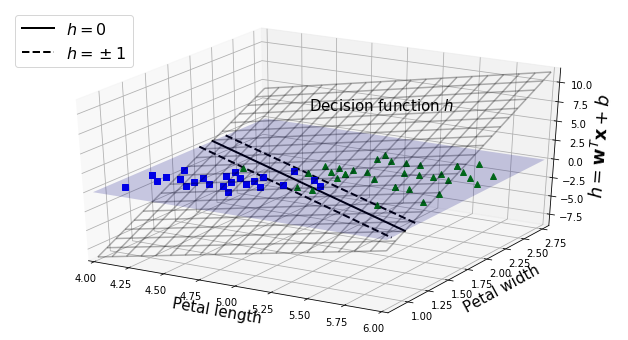

In [18]:
from mpl_toolkits.mplot3d import Axes3D
#Load data
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

#declare the model
scaler = StandardScaler();
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42);
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42);

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ]);
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ]);

#Fit the model
scaled_svm_clf1.fit(X, y);
scaled_svm_clf2.fit(X, y);

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]
def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

#save_fig("iris_3D_plot")
plt.show()

Consider the slope of the decision function: it is equal to the norm of the weight vector, $∥w∥$. If we divide this slope by 2, the points where the decision function is equal to ±1 are going to be twice as far away from the decision boundary. In other words, dividing the slope by 2 will multiply the margin by 2. Perhaps this is easier to be visualized in 2D in the following figure. The smaller the weight vector w, the larger the margin.

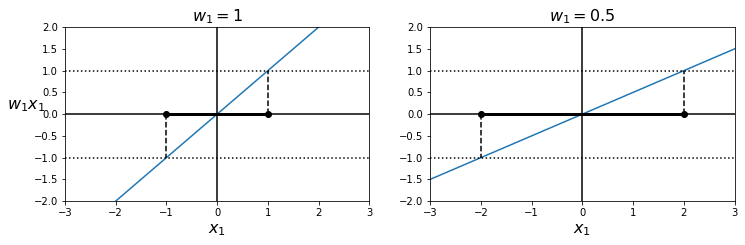

In [19]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

plt.figure(figsize=(12, 3.2))
plt.subplot(121)
plot_2D_decision_function(1, 0)
plt.subplot(122)
plot_2D_decision_function(0.5, 0, ylabel=False)
#save_fig("small_w_large_margin_plot")
plt.show()

So we want to minimize $\left|w\right|$ to get a large margin. However, if we also want to avoid any margin violation (hard margin), then we need the decision function to be greater than 1 for all positive training instances, and lower than $-1$ for negative training instances.

$$t^{(i)} = 2y_i - 1$$
$$ y_i \in\{0,1\}$$
$$ t_i \in\{-1,1\}$$

### hard margin problem
$$ minimize_{w,b}\quad \frac{1}{2} w^tw$$
$$\text{subject to}\quad t^{i} (w^tw^{(i)}+b) \ge 1$$

### soft marging

To get the soft margin objective, we need to introduce a slack variable $\zeta(i) \ge 0$ for each instance: ζ
z(i) measures how much the ith instance is allowed to violate the margin. We now have two conflicting objectives: making the slack variables as small as possible to
reduce the margin violations, and making 12 wT w as small as possible to increase the margin.

This is where the C hyperparameter comes in: it allows us to define the trade-off between these two objectives. This gives us the constrained optimization problem in Equation:

$$ minimize_{w,b}\quad \frac{1}{2} w^tw + C\sum_{i=1}^m \zeta_i$$
$$\text{subject to}\quad t^{i} (w^tw^{(i)}+b) \ge 1- \zeta_i$$
$$\zeta_i \ge 0$$

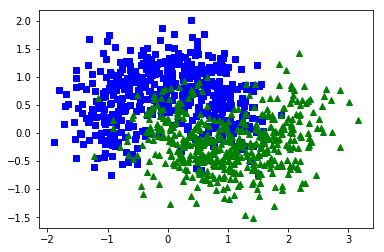

In [20]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.23021697998046875
[LibSVM]1 0.01 0.238569974899292
[LibSVM]2 0.001 0.28883814811706543
[LibSVM]3 0.0001 0.5093920230865479
[LibSVM]4 1e-05 0.8617241382598877
[LibSVM]5 1.0000000000000002e-06 0.8065249919891357
[LibSVM]6 1.0000000000000002e-07 0.8800740242004395
[LibSVM]7 1.0000000000000002e-08 0.8675010204315186
[LibSVM]8 1.0000000000000003e-09 0.8587977886199951
[LibSVM]9 1.0000000000000003e-10 0.8708810806274414


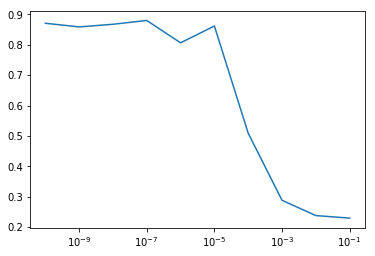

In [21]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times)

# Linear SVM classifier with batch gradient descent

In [22]:
# Training set
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris-Virginica

In [23]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)

array([[1.],
       [0.]])

In [ ]:
svm_clf.fit(X, y)

In [ ]:
svm_clf.predict(np.array([[5, 2], [4, 1]]))

In [ ]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js);
plt.axis([0, svm_clf.n_epochs, 0, 100]);

# Quadratic programming 
The hard margin and soft margin problems are both convex quadratic optimization problems with linear constraints. Such problems are known as Quadratic Programming (QP) problems. Many off-the-shelf solvers are available to solve QP problems using a variety of techniques that are outside the scope of this book.5 The general problem formulation is given by

$$minimize_p \frac{1}{2}p^THp + f^T p$$
$$\text{subject to} \quad Ap \le b$$
where:
 - $p$ is $n_p$ dimensional vector (i.e., the number of parameters)
 - $H$ is $n_p\times n_p$ matrix 
 - $f$ is an $n_p$ dimensional vector
 - $A$ is an $n_c \times n_p$ matrix ($n_c$= number of constrains)
 - $b$ is a  $n_c$ dimensional vector.
 
 
You can easily verify that if you set the QP parameters in the following way, you get the hard margin linear SVM classifier objective:

 - $n_p = n+1;$ n=number of features + 1 for the bias
 - $n_c = m$ number of instances
 - $H$ is the $n_p \times n_p$ identity matrix except a $0$ in the top left to ignore the bias term
 - $f=0$ $n_p$ dimensional vector full of $0$
 - $b=-1$ $n_c$-dimensional vector full of $0$s
 - $a = -t \dot{x}$ where $\dot{x}$ is $x$ with an extra bias feature 1.
 
 So one way to train a hard margin linear SVM classifier is just to use an off-the-shelf QP solver by passing it the preceding parameters. The resulting vector p will contain the bias term b = p0 and the feature weights wi = pi for i = 1, 2, ⋯, n. Similarly, you can use a QP solver to solve the soft margin problem (see the exercises at the end of the chapter).
 


## Online SVM
For linear SVM classifiers, one method is to use Gradient Descent (e.g., using SGDClassifier) to minimize the cost function in Equation 5-13, which is derived from the primal problem. Unfortunately it converges much more slowly than the methods based on QP.

## Hinge loss
The function max(0, 1 – t) is called the hinge loss function (represented below). It is equal to 0 when t ≥ 1. Its derivative (slope) is equal to –1 if t < 1 and 0 if t > 1. It is not differentiable at t = 1, but just like for Lasso Regression (see “Lasso Regression” on page 139) you can still use Gradient Descent using any subderivative at t = 1 (i.e., any value between –1 and 0).

# Exercises
## What is the fundamental idea behind Support Vector Machines?
The fundamental idea behind Support Vector Machines is to fit the widest possible “street” between the classes. In other words, the goal is to have the largest possible margin between the decision boundary that separates the two classes and the training instances. When performing soft margin classification, the SVM searches for a compromise between perfectly separating the two classes and having the widest possible street (i.e., a few instances may end up on the street). Another key idea is to use kernels when training on nonlinear datasets.

## What is a support vector?
After training an SVM, a support vector is any instance located on the “street” (see the previous answer), including its border. The decision boundary is entirely determined by the support vectors. Any instance that is not a support vector (i.e., off the street) has no influence whatsoever; you could remove them, add more instances, or move them around, and as long as they stay off the street they won’t affect the decision boundary. Computing the predictions only involves the sup‐ port vectors, not the whole training set.

## Why is it important to scale the inputs when using SVMs?
SVMs try to fit the largest possible “street” between the classes (see the first answer), so if the training set is not scaled, the SVM will tend to neglect small features/

## Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?
An SVM classifier can output the distance between the test instance and the decision boundary, and you can use this as a confidence score. However, this score cannot be directly converted into an estimation of the class probability. If you set probability=True when creating an SVM in Scikit-Learn, then after training it will calibrate the probabilities using Logistic Regression on the SVM’s scores (trained by an additional five-fold cross-validation on the training data). This will add the predict_proba() and predict_log_proba() methods to the SVM.

## Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?
This question applies only to linear SVMs since kernelized can only use the dual form. The computational complexity of the primal form of the SVM problem is proportional to the number of training instances $m$, while the computational complexity of the dual form is proportional to a number between $m^2$ and $m^3$. So if there are millions of instances, you should definitely use the primal form, because the dual form will be much too slow.

## Say you trained an SVM classifier with an RBF kernel. It seems to underfit the training set: should you increase or decrease γ (gamma)? What about C?
If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. To decrease it, you need to increase gamma or C (or both).

## How should you set the QP parameters (H, f, A, and b) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?
Let’s call the QP parameters for the hard-margin problem H′, f′, A′ and b′ (see “Quadratic Programming” on page 159). The QP parameters for the soft-margin problem have m additional parameters (np = n + 1 + m) and m additional con‐ straints (nc = 2m). They can be defined like so:

 - H is equal to H′, plus m columns of 0s on the right and m rows of 0s at the bottom: 

    H = [H' | 0 ...]
        [0..| 0 ...]
    
 - f is equal to f′ with m additional elements, all equal to the value of the hyper‐ parameter C.
 - b is equal to b′ with m additional elements, all equal to 0.
 - A is equal to A′, with an extra m × m identity matrix Im appended to the right,
 
 A= [A' Im
    [0. Im]


## Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [ ]:
from sklearn import datasets
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:

C = 5
# In the SGD classifier alpha multiplies the regularization term
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=100000, tol=-np.infty, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)
print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28474532] [[1.05364923 1.09903601]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.319] [[1.12072936 1.02666842]]


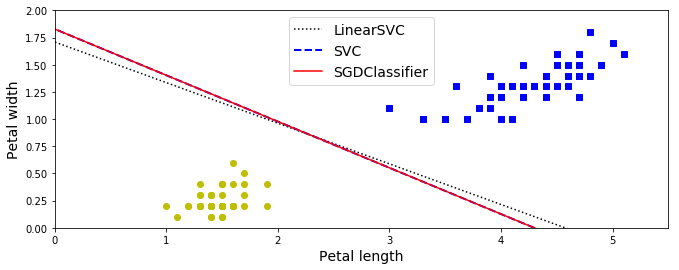

In [ ]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
# it creates a line in the scaled space (2 points) and then convert it
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

## train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

First, let's load the dataset and split it into a training set and a test set. We could use train_test_split() but people usually just take the first 60,000 instances for the training set, and the last 10,000 instances for the test set (this makes it possible to compare your model's performance with others):

In [3]:
import numpy as np;
from sklearn.svm import LinearSVC, SVC;
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

Many training algorithms are sensitive to the order of the training instances, so it's generally good practice to shuffle them first:

In [7]:
np.random.seed(42)
rnd_idx = np.random.permutation(60000)
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do. Easy!

In [8]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train[:10000], y_train[:10000])

/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Let's make predictions on the training set and measure the accuracy (we don't want to measure it on the test set yet, since we have not selected and trained the final model yet):

In [9]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.858

Wow, 86% accuracy on MNIST is a really bad performance. This linear model is certainly too simple for MNIST, but perhaps we just needed to scale the data first:

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler();
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32));
X_test_scaled = scaler.transform(X_test.astype(np.float32));
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled[:10000], y_train[:10000])

/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [12]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9206

hat's much better (we cut the error rate in two), but still not great at all for MNIST. If we want to use an SVM, we will have to use a kernel. Let's try an SVC with an RBF kernel (the default).

In [14]:
svm_clf = SVC(decision_function_shape="ovr", gamma="auto")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
y_pred = svm_clf.predict(X_train_scaled[:10000])
accuracy_score(y_train, y_pred)

0.94745

That's promising, we get better performance even though we trained the model on 6 times less data. Let's tune the hyperparameters by doing a randomized search with cross validation. We will do this on a small dataset just to speed up the process:

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.6s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.6s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................
[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.6s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   0.7s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   0.7s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   0.7s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   0.7s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   0.7s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.6s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a449ceeb8>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a4490e400>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [22]:
rnd_search_cv.best_estimator_

SVC(C=8.852316058423087, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [23]:
rnd_search_cv.best_score_

0.864

In [24]:
from sklearn.metrics import mean_squared_error, accuracy_score
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.8888


Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [25]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.8953

# Train an SVM regressor on the California housing dataset.

In [38]:
import os, tarfile;
from six.moves import urllib;
import pandas as pd;
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing();
X = data['data'];
y = data['target'];

In [39]:
!ls

=                 SVM.ipynb         housing.csv
Press             SVMComparison.png housing.tgz


In [41]:
from sklearn.model_selection import train_test_split;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

In [42]:
del X, y;

In [44]:
data["feature_names"]

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [46]:
data["DESCR"]

'.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 20640\n\n    :Number of Attributes: 8 numeric, predictive attributes and the target\n\n    :Attribute Information:\n        - MedInc        median income in block\n        - HouseAge      median house age in block\n        - AveRooms      average number of rooms\n        - AveBedrms     average number of bedrooms\n        - Population    block population\n        - AveOccup      average house occupancy\n        - Latitude      house block latitude\n        - Longitude     house block longitude\n\n    :Missing Attribute Values: None\n\nThis dataset was obtained from the StatLib repository.\nhttp://lib.stat.cmu.edu/datasets/\n\nThe target variable is the median house value for California districts.\n\nThis dataset was derived from the 1990 U.S. census, using one row per census\nblock group. A block group is the smallest geographical unit

## Plots for notes

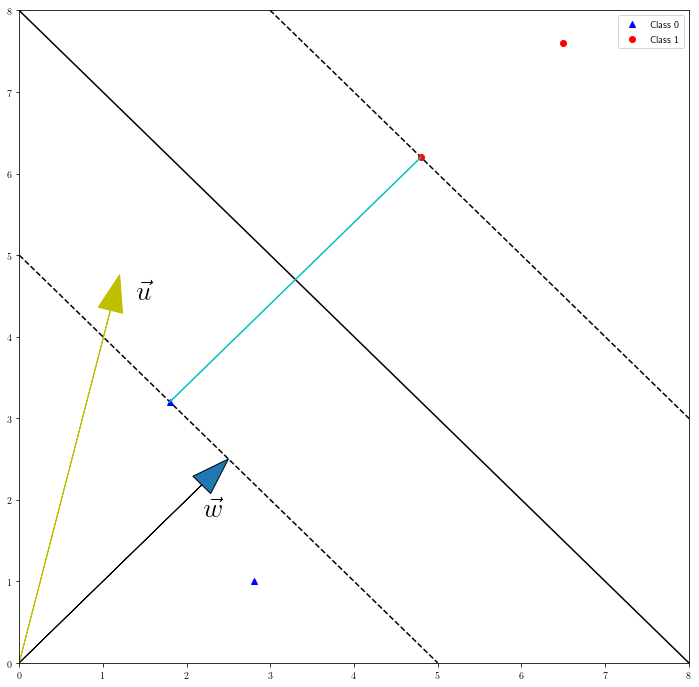

In [108]:
plt.figure(figsize=(12,12))
solid_line   = [[0,8],[8,0]];
lower_margin = [[0,5],[5,0]];
upper_margin = [[0,11],[11,0]];
class0 = np.array([[1.8,2.8], [3.2, 1]]);
class1 = np.array([[4.8,6.5], [6.2, 7.6]]);

plt.plot(solid_line[0],solid_line[1], 'k');
plt.plot(lower_margin[0],lower_margin[1], '--k');
plt.plot(upper_margin[0],upper_margin[1], '--k');
plt.axis((0,8, 0,8));
w = np.array([2.5,2.5]);
u = np.array([1.2,4.76]);
u_perp_w = w *u.dot(w)/w.dot(w); #projection
plt.plot(class0[0,:],class0[1,:],'^b', label="Class 0");
plt.plot(class1[0,:],class1[1,:],'or', label="Class 1");
plt.plot([class0[0,0],class1[0,0]], [class0[1,0],class1[1,0]],'c');
plt.legend();
plt.arrow(0,0,w[0],w[1], head_width=0.3, length_includes_head=True);
plt.arrow(0,0,u[0],u[1], head_width=0.3, length_includes_head=True, color='y');
#plt.arrow(0,0,u_perp_w[0],u_perp_w[1], head_width=0.3, length_includes_head=True, color='y', ls="-.");


plt.text(2.2,1.8, r'$\vec{w}$', fontsize=28);
plt.text(u[0]+0.2,u[1]-0.3, r'$\vec{u}$', fontsize=28);
#plt.text(u_perp_w[0]+0.1,u_perp_w[0]-0.4, r'$\vec{u}\bot \vec{w}$', fontsize=28);

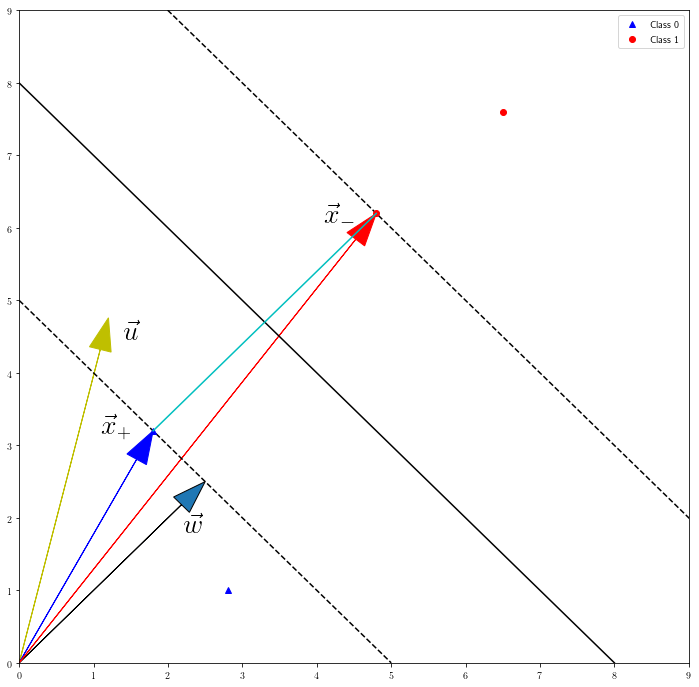

In [106]:
plt.figure(figsize=(12,12))
solid_line   = [[0,8],[8,0]];
lower_margin = [[0,5],[5,0]];
upper_margin = [[0,11],[11,0]];
class0 = np.array([[1.8,2.8], [3.2, 1]]);
class1 = np.array([[4.8,6.5], [6.2, 7.6]]);

plt.plot(solid_line[0],solid_line[1], 'k');
plt.plot(lower_margin[0],lower_margin[1], '--k');
plt.plot(upper_margin[0],upper_margin[1], '--k');
plt.axis((0,9, 0,9));
w = np.array([2.5,2.5]);
u = np.array([1.2,4.76]);
x_plus = class0[:,0];
x_minus = class1[:,0];

u_perp_w = w *u.dot(w)/w.dot(w); #projection
plt.plot(class0[0,:],class0[1,:],'^b', label="Class 0");
plt.plot(class1[0,:],class1[1,:],'or', label="Class 1");
plt.plot([class0[0,0],class1[0,0]], [class0[1,0],class1[1,0]],'c');
plt.legend();
plt.arrow(0,0,w[0],w[1], head_width=0.3, length_includes_head=True);
plt.arrow(0,0,u[0],u[1], head_width=0.3, length_includes_head=True, color='y');
plt.arrow(0,0,x_plus[0], x_plus[1], head_width=0.3, length_includes_head=True, color='b');
plt.arrow(0,0,x_minus[0], x_minus[1], head_width=0.3, length_includes_head=True, color='r');
#plt.arrow(0,0,u_perp_w[0],u_perp_w[1], head_width=0.3, length_includes_head=True, color='y', ls="-.");


plt.text(2.2,1.8, r'$\vec{w}$', fontsize=28);
plt.text(u[0]+0.2,u[1]-0.3, r'$\vec{u}$', fontsize=28);
plt.text(x_plus[0]-0.7,x_plus[1]+0.2-0.3, r'$\vec{x}_+$', fontsize=28);
plt.text(x_minus[0]-0.7,x_minus[1]+0.2-0.3, r'$\vec{x}_-$', fontsize=28);

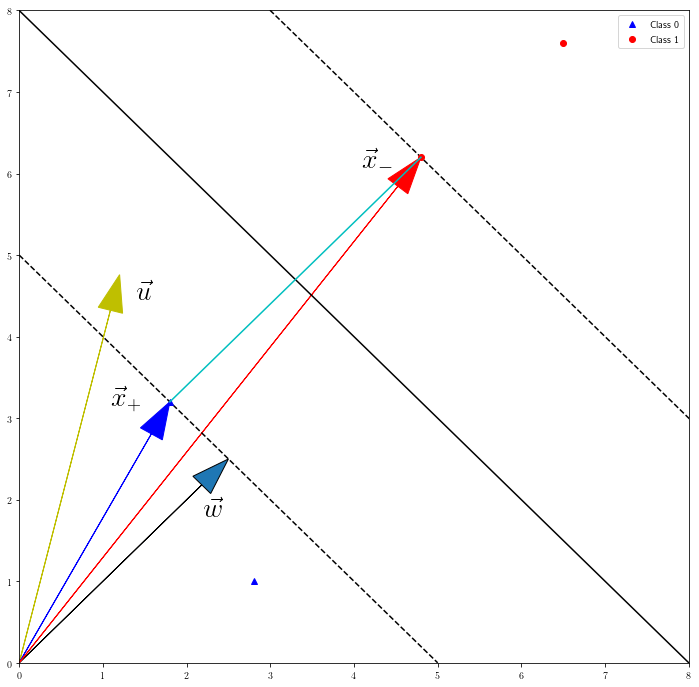

In [109]:
plt.figure(figsize=(12,12))
solid_line   = [[0,8],[8,0]];
lower_margin = [[0,5],[5,0]];
upper_margin = [[0,11],[11,0]];
class0 = np.array([[1.8,2.8], [3.2, 1]]);
class1 = np.array([[4.8,6.5], [6.2, 7.6]]);

plt.plot(solid_line[0],solid_line[1], 'k');
plt.plot(lower_margin[0],lower_margin[1], '--k');
plt.plot(upper_margin[0],upper_margin[1], '--k');
plt.axis((0,8, 0,8));
w = np.array([2.5,2.5]);
u = np.array([1.2,4.76]);
x_plus = class0[:,0];
x_minus = class1[:,0];

u_perp_w = w *u.dot(w)/w.dot(w); #projection
plt.plot(class0[0,:],class0[1,:],'^b', label="Class 0");
plt.plot(class1[0,:],class1[1,:],'or', label="Class 1");
plt.plot([class0[0,0],class1[0,0]], [class0[1,0],class1[1,0]],'c');
plt.legend();
plt.arrow(0,0,w[0],w[1], head_width=0.3, length_includes_head=True);
plt.arrow(0,0,u[0],u[1], head_width=0.3, length_includes_head=True, color='y');
plt.arrow(0,0,x_plus[0], x_plus[1], head_width=0.3, length_includes_head=True, color='b');
plt.arrow(0,0,x_minus[0], x_minus[1], head_width=0.3, length_includes_head=True, color='r');
#plt.arrow(0,0,u_perp_w[0],u_perp_w[1], head_width=0.3, length_includes_head=True, color='y', ls="-.");


plt.text(2.2,1.8, r'$\vec{w}$', fontsize=28);
plt.text(u[0]+0.2,u[1]-0.3, r'$\vec{u}$', fontsize=28);
plt.text(x_plus[0]-0.7,x_plus[1]+0.2-0.3, r'$\vec{x}_+$', fontsize=28);
plt.text(x_minus[0]-0.7,x_minus[1]+0.2-0.3, r'$\vec{x}_-$', fontsize=28);